In [22]:
import pandas as pd
import sys

from scipy.optimize import minimize
from scipy.stats import norm, uniform, binom
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

execfile("04-utils.py")

## Bayesian linear modeling

Now that we explored in detail the population height, we can finally start our studying on the relationship between weight and height.

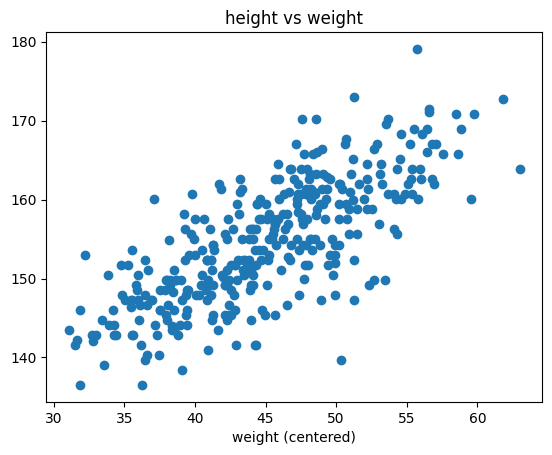

In [23]:
data = pd.read_csv('04-howell1.csv', sep = ';')
data1 = data[data.age>=18]

plt.scatter(data1.weight, data1.height)
plt.title('height vs weight')
plt.xlabel('height (cm)')
plt.xlabel('weight (centered)')
plt.show()

The dataset *Howell* contains partial census data for the Dobe area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960s.

At this point we need to increase a bit the complexity of out Bayesian model, as we are now performing a *regression*.
In particular, we are interested in the relationship:

$$\text{height} = a + b * \text{weight},$$

and we would like to obtain posterior distributions for the regression coefficients $a$ and $b$. As in classical regression models, the variable $a$ is called *intercept*, and expresses the age we expect when the weight is 0, and $b$ is the *slope*, which indicates how much the height changes for a unit increase of weight.

To proceed with our Bayesian treatment, the trick here is to assume that our previous Gaussian model of height is indeed dependent on the variable weight through this linear relationship. In this case, the height of an individual $i$ is a sample from a Gaussian model:

$$\text{height}_i\sim N(\mu_i,\sigma^2),$$

whiel this time we impose that $\mu_i = a + b * \text{weight}_i$. Note that while we allow the mean $\mu_i$ to vary depending on the weight, the coefficients $a$ and $b$, as well as the noise $\sigma$ are the same across subjects.  
To completely define our Bayesian model, we need to specify priors for all the parameters we want to analyze:

$$ p(a) = N(178, 1000),$$

$$ p(b) = N(0, 100),$$

$$ p(\sigma) = U(0, 50).$$

We code all these elements to run our black-box machine:

In [24]:
expr = 'height ~ weight'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

And we are finally ready to perform inference:


In [25]:
solution_regression = laplace_solution_regression(expr, data1, likelihood, priors)


/home/joris/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 1083.8791047602379
 hess_inv: array([[ 1.63403539e+00, -3.58180562e-02,  6.20635066e-03],
       [-3.58180562e-02,  8.16102724e-04, -1.46970634e-04],
       [ 6.20635066e-03, -1.46970634e-04,  3.92513813e-02]])
      jac: array([0.       , 0.0002594, 0.       ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 293
      nit: 25
     njev: 70
   status: 2
  success: False
        x: array([113.90342096,   0.90450548,   5.07186724])


As before, we can sample from our posterior to explore the distribution of our model parameters: 

In [26]:
posterior_samples = multivariate_normal.rvs(solution_regression[0], solution_regression[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary = pd.DataFrame(summary_stats).transpose()
summary.columns = ['mean', 'SD', '7.5%', '92.5%']
summary.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary)

             mean        SD        7.5%       92.5%
a      113.862128  1.343031  111.982272  115.808715
b        0.905403  0.029946    0.861919    0.947179
sigma    5.073582  0.194720    4.785566    5.353994


In [27]:
summary

,mean,SD,7.5%,92.5%
a,113.862128,1.343031,111.982272,115.808715
b,0.905403,0.029946,0.861919,0.947179
sigma,5.073582,0.194720,4.785566,5.353994


We try to run the model again by centering the data, what is the difference in the posteriors? Can you explain this difference?

In [28]:
# Centering the data
mean_weight = np.mean(data1.weight)
data_center = data1
data_center.weight = data1.weight - mean_weight

# Fitting the model again
solution_regression_center = laplace_solution_regression(expr, data_center, likelihood, priors)

/tmp/ipykernel_13600/8220345.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_center.weight = data1.weight - mean_weight


      fun: 1083.700995967059
 hess_inv: array([[ 0.0982827 , -0.09850122, -0.19686421],
       [-0.09850122,  0.10139365,  0.20043056],
       [-0.19686421,  0.20043056,  0.3983657 ]])
      jac: array([-1.52587891e-05,  0.00000000e+00,  0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 160
      nit: 27
     njev: 40
   status: 2
  success: False
        x: array([154.59726323,   0.90501318,   5.07186626])


In [29]:
# Computing posterior samples
posterior_samples_center = multivariate_normal.rvs(solution_regression_center[0], solution_regression_center[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples_center, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples_center, axis = 0)
# mean
post_mean = np.mean(posterior_samples_center, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary_stats = pd.DataFrame(summary_stats).transpose()
summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
summary_stats.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary_stats)

             mean        SD        7.5%       92.5%
a      154.601018  0.311061  154.141161  155.057278
b        0.901700  0.316976    0.438338    1.360707
sigma    5.064207  0.627848    4.147952    5.948503


Once obtained the parameters, we can start exploring the model.
Let's plot the average prediction along the entire weight range:

[154.6010181    0.9017003    5.06420688]


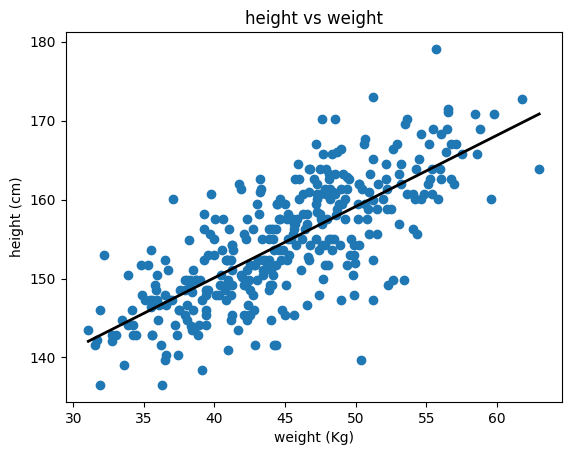

In [30]:
#plotting the average results 
print(post_mean)

x_range = np.linspace(min(data_center.weight), max(data_center.weight))
mean_prediction = post_mean[0] + post_mean[1] * x_range

plt.plot(x_range + mean_weight, mean_prediction, lw = 2, color = 'black')
plt.scatter(data_center.weight + mean_weight,data_center.height)
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')
plt.show()

Now we can explore the variability of the prediction, this can be done by using the posterior samples for the coefficients that we computed before:

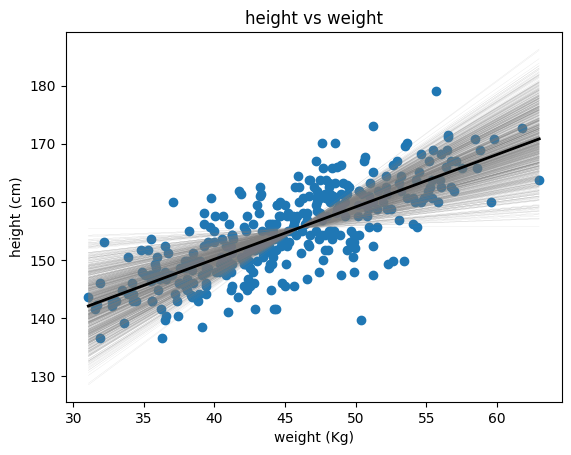

In [31]:
#sampling from the posterior

for i in range(1000):
    prediction = posterior_samples_center[i,0] + posterior_samples_center[i,1] * x_range
    plt.plot(x_range + mean_weight, prediction, lw = 0.05, color = 'grey')

plt.scatter(data_center.weight + mean_weight,data_center.height)
plt.plot(x_range + mean_weight, mean_prediction, lw = 2, color = 'black')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')


plt.show()

By following the same modeling procedure, we can study how the uncertainty on the estimation of the coefficients varies with the different sample sizes: 

      fun: 71.32545922183913
 hess_inv: array([[1.14379506e+00, 1.33963290e-02, 4.74192833e-03],
       [1.33963290e-02, 1.75878185e-02, 2.07245252e-04],
       [4.74192833e-03, 2.07245252e-04, 5.88141122e-01]])
      jac: array([ 9.53674316e-07, -3.81469727e-06, -9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 15
     njev: 19
   status: 0
  success: True
        x: array([153.55884728,   0.86866266,   4.74646062])


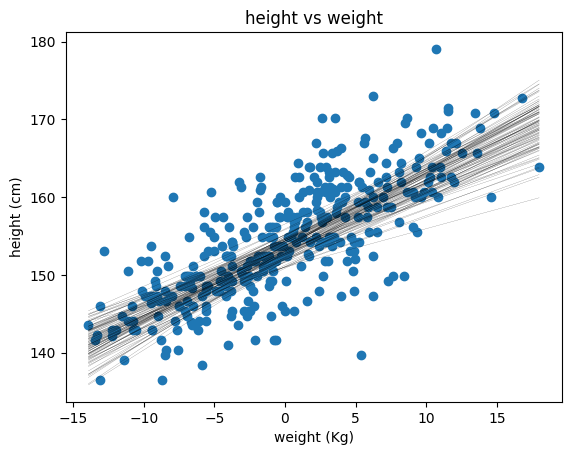

      fun: 161.31066747857793
 hess_inv: array([[0.31173169, 0.00605642, 0.00409908],
       [0.00605642, 0.00865199, 0.00065492],
       [0.00409908, 0.00065492, 0.22336132]])
      jac: array([-3.81469727e-06,  7.62939453e-06,  1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 120
      nit: 27
     njev: 30
   status: 0
  success: True
        x: array([152.92544721,   0.88971205,   4.80911479])


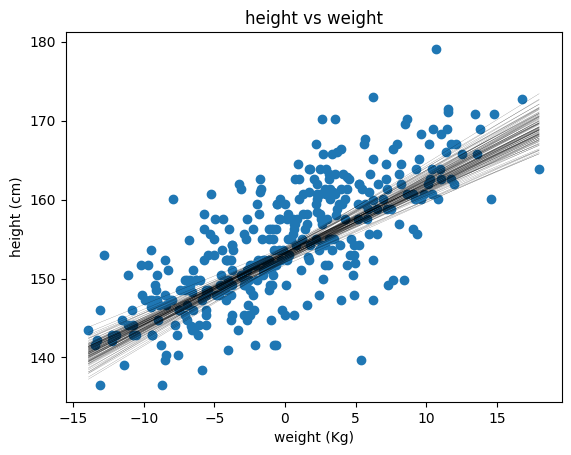

      fun: 478.3211606409005
 hess_inv: array([[ 1.96317517e-01, -2.03379975e-03,  1.96127556e-05],
       [-2.03379975e-03,  4.14139581e-03,  2.40147392e-04],
       [ 1.96127556e-05,  2.40147392e-04,  9.97081196e-02]])
      jac: array([7.62939453e-06, 3.81469727e-06, 3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 16
     njev: 20
   status: 0
  success: True
        x: array([153.83813332,   0.90193027,   5.42665197])


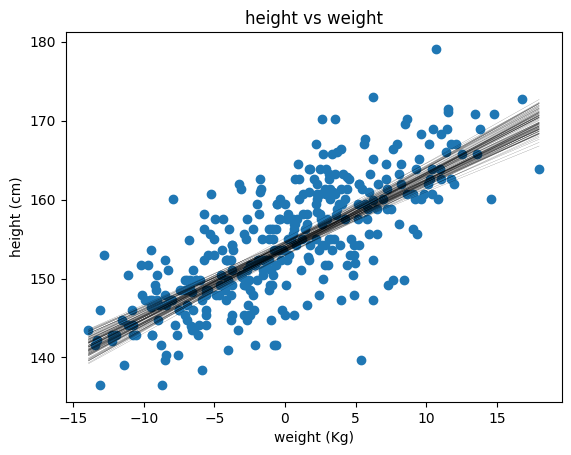

/home/joris/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 1076.6635796350135
 hess_inv: array([[ 0.00448947,  0.00022882, -0.00046318],
       [ 0.00022882,  0.00185898, -0.0001852 ],
       [-0.00046318, -0.0001852 ,  0.01004126]])
      jac: array([ 0.00000000e+00, -3.05175781e-05,  0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 115
      nit: 18
     njev: 28
   status: 2
  success: False
        x: array([154.62813482,   0.91056835,   5.07189301])


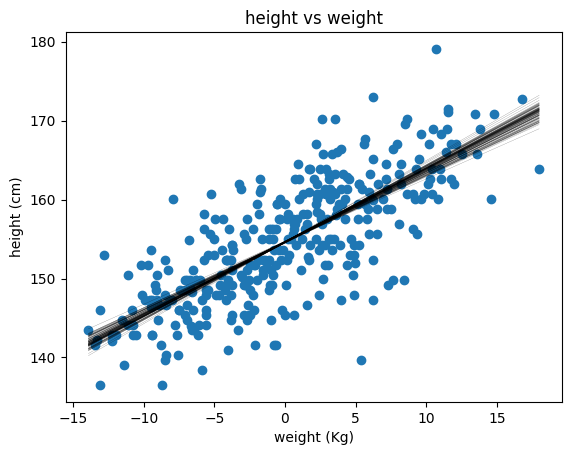

In [32]:
# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 20
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Posterior uncertainty vs sample size

for N in [20,50,150,350]:
    
    # Selecting a subset of the data with sample size = N
    sub_data = data_center.head(N)
    # Fitting the model again
    R = laplace_solution_regression(expr, sub_data, likelihood, priors)

    # Computing posterior samples
    post_R = multivariate_normal.rvs(R[0], R[1], size = 1000)

    for i in range(100):
        prediction = post_R[i,0] + post_R[i,1] * x_range
        plt.plot(x_range, prediction, lw = 0.1, color = 'black')

    plt.scatter(data1.weight,data1.height)
    plt.title('height vs weight')
    plt.ylabel('height (cm)')
    plt.xlabel('weight (Kg)')


    plt.show()  

The model also allows us to quantify the uncertainty of the prediction for a single odata point.

**Exercise.** Predict the height distribution for a person of 50Kg.

In [74]:
from typing import Union
import plotly.express as px
import numpy as np


def sample_given_weight(weight: Union[int, float]):
  """Return samples of one prediction per model."""
  samples_given_kg = post_R[:, 0] + post_R[:, 1] * (weight - mean_weight)
  return samples_given_kg


samples_50_kg = sample_given_weight(weight=50)

conf_level = 0.95
q_low = (1 - conf_level) / 2
q_high = 1 - q_low
quantiles = np.quantile(samples_50_kg, q=[q_low, q_high])

fig = px.histogram(samples_50_kg)
for stat in [samples_50_kg.mean(), *quantiles]:
  fig.add_vline(x=stat)

fig.update_layout(
  title=f"""Mean prediction for 50 kg: {samples_50_kg.mean():.2f} cm, 
  Std: {samples_50_kg.std():.2f},
  {100*conf_level} CI bounds: {np.round(quantiles, 2)}"""
)


**Exercise.** Repeat the exercise for the entire range of weights:

In [75]:
range_x_test = np.linspace(30,65)
x_range_center = range_x_test - mean_weight



So far we analyzed only the uncertainty related to the mean prediction, but we see that many data points fall clearly beyond the confidence interval.  
We can estimate the overall posterior uncertainty of the prediction, while accounting for the estimated regression noise. 
This requires to sample from the data posterior, accounting for the variability for both regression coefficients and modelled noise:

(50, 500)

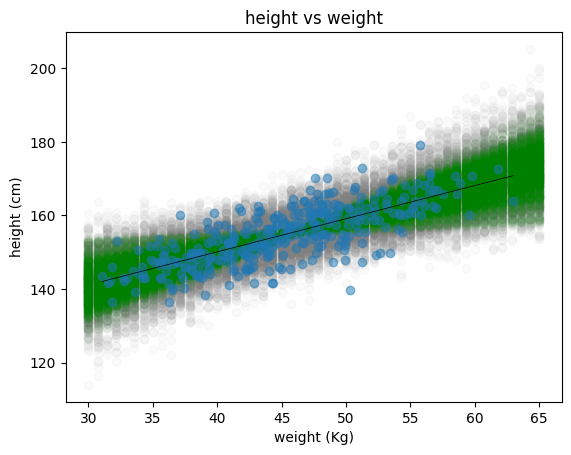

In [90]:
prediction_range = []
# sampling from the posterior to get a predictive interval
for x_ in x_range_center:
  prediction_range.append(
    posterior_samples_center[:500, 0] + posterior_samples_center[:500, 1] * x_
  )

prediction_range_noise = []

# sampling from the posterior to get a predictive interval
for x_ in x_range_center:
  prediction_range_noise.append(
    norm.rvs(
      posterior_samples_center[:500, 0] + posterior_samples_center[:500, 1] * x_,
      posterior_samples_center[:500, 2],
    )
  )

# Plotting the uncertainty
for i, x_ in enumerate(x_range_center):
  plt.scatter(
    np.repeat(x_, 500) + mean_weight,
    prediction_range_noise[i],
    alpha=0.04,
    color="grey",
  )
for i, x_ in enumerate(x_range_center):
  plt.scatter(
    np.repeat(x_, 500) + mean_weight, prediction_range[i], alpha=0.03, color="green"
  )


plt.scatter(data1.weight + mean_weight, data1.height, alpha=0.5)
plt.plot(x_range + mean_weight, mean_prediction, lw=0.5, color="black")
plt.title("height vs weight")
plt.ylabel("height (cm)")
plt.xlabel("weight (Kg)")
plt.plot()
np.array(prediction_range_noise).shape

**Exercise.** Include the individual with age less than 18 years, and repeat the analysis. 

Which kind of model would you use for modeling this data?

In [96]:
px.scatter(data, x="weight", y="height")

In [99]:
data["weight_sq"] = data["weight"]**2
data

,height,weight,age,male,weight_sq
0,151.765,47.825606,63.0,1,2287.288637
1,139.700,36.485807,63.0,0,1331.214076
2,136.525,31.864838,65.0,0,1015.367901
3,156.845,53.041914,41.0,1,2813.444694
4,145.415,41.276872,51.0,0,1703.780162
...,...,...,...,...,...
539,145.415,31.127751,17.0,1,968.936882
540,162.560,52.163080,31.0,1,2720.986915
541,156.210,54.062497,21.0,0,2922.753528
542,71.120,8.051258,0.0,1,64.822755
